# Homework 3
**Total Points: 5**

**Instructions:**
1. Complete parts 1 through 5, filling in code or responses where marked with `# YOUR CODE HERE` or `# YOUR ANALYSIS HERE`.
2. The libraries you need, in the order you need them, have already been coded. Do not import additional libraries or move import commands.
3. When finished, run the full notebook by selecting <b>Kernel > Restart & Run All</b>. </li>
4. Submit this completed notebook file to <b>NYU Classes</b>. </li>

This assignment contains a subfolder called `audio` which has 6 short audio files. Three of the files have an accompanying "_reference" file which has comma-separated reference onsets for your evaluation.

**Grading:** Each part is worth 1 point.

In [1]:
import numpy as np
import librosa
from matplotlib import pyplot as plt
from scipy import signal
import pandas as pd

## Part 1: Energy-Based Novelty Function
Create an energy-based novelty function `energy_novelty()` where the input is an audio signal and the output is the novelty curve of that audio. This function should (1) compute the local energy for each frame, (2) find the first order difference of the local energy, and (3) use half-wave rectification to account only for energy increases. Use `scipy.signal.hann()` to generate a hann window as needed.

In [2]:
def energy_novelty(x, win_size):
    
    """ Calulate an energy-based novelty curve
    
    Parameters
    ----------
    
    x: np.array
        input audio
    
    win_size: int
        samples to advance before next energy calculation aka n_fft
        
    Returns
    -------
    
    novelty: np.array
        novelty curve
        
    """
    N = win_size
    w = signal.hann(N)

    #Calculate local energy
    x_square = x**2
    energy_local = np.convolve(x_square, w**2 , 'same')

    #rmse_diff = np.zeros_like(rmse) #difference
    energy_local_diff = np.diff(energy_local)
    energy_local_diff = np.concatenate((energy_local_diff, np.array([0])))

    # half wave rectification to account for
    novelty_energy = np.copy(energy_local_diff)
    novelty_energy[energy_local_diff < 0] = 0

    return novelty_energy
    
    


# Part 2: Spectral Flux Novelty Function
Create a function `spectral_flux_novelty()` where the input is an audio signal and the output is the spectral flux novelty curve of that audio. This function should first (1) compute the STFT of the input audio (use `librosa.stft()` where n_fft = win_size and the window type is hann), and (2) compress the spectrogram to highlight the high-frequency content (use $y=50$ or create an additional parameter if you want). 

In [3]:
def spectral_flux_novelty(x, win_size, hop_size):
    
    """ Calulate a spectral flux novelty curve
    
    Parameters
    ----------
    
    x: np.array
        input audio
    
    win_size: int
        window size (samples)
    
    hop_size: int
        hop size (samples)
        
    Returns
    -------
    
    novelty: np.array
        novelty curve
        
    """
    # compute stft
    X = librosa.stft(x, n_fft=win_size, hop_length=hop_size, win_length=win_size, window='hanning') 
    
    # compress spectrogram to highlight high frequency content. 
    gamma = 50
    Y = np.log(1 + gamma * np.abs(X)) # a log-comp stft which is a matrix. dims 1025 by 44
    
    # difference spectrum (set first diff to zero)
    Y_diff = np.diff(Y, n=1)
    Y_diff[Y_diff < 0] = 0
    nov = np.sum(Y_diff, axis=0)
    nov = np.concatenate((nov, np.array([0])))
    Fs_nov = fs/hop_size
    
    return nov

### Test your Novelty Functions
Use the space below to test your novelty function. Plot the novelty curves to make sure the output appears as expected. Use the included `drums2.aif` file.

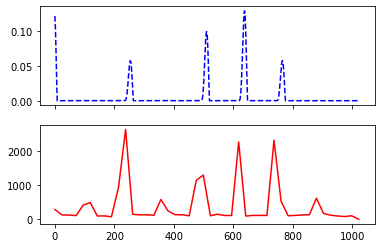

<Figure size 1080x432 with 0 Axes>

<Figure size 1080x432 with 0 Axes>

In [4]:
x, fs = librosa.load("audio/drums.aif") # load audio file

win_size = 2048
hop_size = 1024
rmse = energy_novelty(x, win_size) # call 1st novelty function
spectral_flux = spectral_flux_novelty(x, win_size, hop_size) # call 2nd enegy function

fig, (ax1, ax2) = plt.subplots(2, sharex=True)
# plot the novelty curve
frames = np.arange(len(rmse))
t = librosa.frames_to_time(frames, sr=fs)
plt.figure(figsize=(15, 6))
ax1.plot(t, rmse, 'b--')

# plot 2
frames = np.arange(len(spectral_flux))
t2 = librosa.frames_to_time(frames, sr=fs/hop_size)
plt.figure(figsize=(15, 6))
ax2.plot(t2, spectral_flux, 'r-')


## Part 3: Detect Onsets
Create a function `detect onsets()` where the input is the novelty curve and the output is a numpy array of estimated onsets.

In [5]:
def detect_onsets (n_fn, mean_len, max_len, delta):
    
    """ Detect onsets from a novelty curve
    
    Parameters
    ----------
    
    n_fn: np.array
        input novelty curve
    
    mean_len: int
        before and after each sample, used to calculate threshold. 
    
    max_len: int
        window around n used to determine if n is a peak. 
        
    delta: int
         amount to vertically adjust the threshold (start with delta = 0.05) up/down
      
    
    Returns
    -------
    
    onsets: np.array
        detected onsets (frame number)

    """
    # using librosa peaks function to find detected onsets
    peaks = librosa.util.peak_pick(n_fn, max_len, max_len, mean_len, mean_len, delta, 2)
    
    return peaks 

## Part 4: Evaluation
Create a function `evaluate onsets()` where the input is the reference and detected onsets, and the output is the precision, recall, and f-measure (see function description for implementation details regarding the output).

In [6]:
def evaluate_onsets(reference_onsets, detected_onsets, tolerance):
    
    """ Calculate the precision, recall, and F-measure of the onsets.
    
    Parameters
    ----------
    
    reference_onsets: np.array
        reference onsets
    
    detected_onsets: np.array
        detected onsets
    
    tolerance: int
        tolerance window (samples)
        
    
    Returns
    -------
    
    eval: np.array
        Three-element np.array with Precusion, Recall, and F-Measure
    
    """
    truepos = 0
    
    for i in range(len(detected_onsets)):
        for n in range(len(reference_onsets)):
            min1 = reference_onsets[n] - tolerance
            max1 = reference_onsets[n] + tolerance
            if detected_onsets[i] >= min1 and detected_onsets[i]<= max1:
                truepos += 1
    
    falsepos = len(detected_onsets) - truepos
    falseneg = len(reference_onsets) - truepos
    
    print ("truepos: ")
    print (truepos)
    print ("falsepos: ")
    print (falsepos)
    print ("falseneg: ")
    print (falseneg)
    
    # calculating precision, recall, and f-measure based on values above
    precision = truepos/(truepos + falsepos)
    recall = truepos/(truepos + falseneg)
    fmeas = (2 * precision * recall) / (precision + recall)
    
    eval = np.array([precision, recall, fmeas]) # final array
    
    return eval


### Test Onsets and Evaluation
Use this section to test your onset detection/peak picking code and your evaluation code. Use `drums.aif` and the reference onsets below.

In [7]:
x, fs = librosa.load("audio/drums.aif")
win_size = 2048
hop_size = 1024 

# given reference onsets
reference_onsets = np.array([0.0, 0.25, 0.5, 0.75,  1.0, 1.25, 1.5, 1.75]) #drums
#reference_onsets = np.array([0.0, 0.750, 1.125, 1.312, 1.50, 1.688, 2.250, 2.812, 3.188, 3.375]) #guitar
#reference_onsets = np.array([0.02321995, 0.65015873, 1.27709751, 2.32199546, 2.48453515, 2.67029478, 3.29723356, 4.57433107]) #trumpet

n_fn = spectral_flux_novelty(x, win_size, hop_size) #use spectral flux function

# convert to seconds
frames = np.arange(len(n_fn))
t = librosa.frames_to_time(frames, sr=fs)

mean_len = 3
max_len = 3
delta = .05
detected_onsets = detect_onsets (n_fn, mean_len, max_len, delta)
detected_onsets = detected_onsets * hop_size / fs # convert to seconds

tolerance = .070 #70 ms
evaluate_onsets(reference_onsets, detected_onsets, tolerance) # call evaluate_onsets above

truepos: 
8
falsepos: 
0
falseneg: 
0


array([1., 1., 1.])

## Part 5: Analysis
Using the audio files and your code in Parts 1 - 4, report on the novelty function and parameters that generate the most accurate results. In your report, include plots and dataframes as necessary to illustrate your findings. Also comment on the character of each audio file included and how that that character may affect how well (or how poorly) a particular onset detection technique may work.

(OPTIONAL) If you would like to modify a novelty function or the onset detection process from this assignment, please do so by creating a new function. For example, you may wish to pre-process the novelty curve by applying a smoothing function or by adjusting the peak-picking parameters. If you do decide to create a new function, please comment it thoroughly. If your changes are based on prior academic literature (or web sites), please cite those references appropriately.

Text(0, 1, 'Evaluation of Spectral Flux Function')

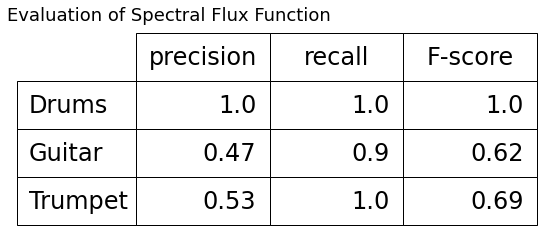

In [8]:
# plot figure of the 3 values for all 3 audio files
fig = plt.figure()
ax = fig.add_subplot(111)
col_labels = ['precision', 'recall', 'F-score']
row_labels = ['Drums', 'Guitar', 'Trumpet']
table_vals = [[1.0, 1.0, 1.0], [.47, .90, .62], [.53, 1.0, .69]]

# Draw table
the_table = plt.table(cellText=table_vals,
                      colWidths=[0.1] * 3,
                      rowLabels=row_labels,
                      colLabels=col_labels,
                      loc='center')
the_table.auto_set_font_size(False)
the_table.set_fontsize(24)
the_table.scale(4, 4)

# Removing ticks and spines enables you to get the figure only with table
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)
plt.savefig('matplotlib-table.png', bbox_inches='tight', pad_inches=0.05)

# Add title
plt.text(0,1,'Evaluation of Spectral Flux Function',size=18, horizontalalignment='center')


### Results & Analysis: (see plot above)

### Drums
For drums, I got an F score of 1.0, hooray! Precision and recall were also 1.0 I got 0 false positives and 0 false negatives. 
This is an indication that my algorithm works great for drums! Drums have a loud, crisp, and clear attack, so it makes sense transients are easier to detect.
### Guitar
For guitar, I got an F score of 0.62. Precision and recall were .47 and .9, respectively. There was a high rate of false positives - 10 of them, and only one false negative.
This file is an exapmple of somewhere with high recall but low precision. The algorithm is right a lot of the time, but it over-selects transients. 
### Trumpet
Finally for trumpet, I got an F score of 0.69. Precision and recall were .53 and 1, respectively. There was a high rate of false positives - 7, but no false negatives.
Again, there is high (even perfect!) recall but low precision. That seems to be the case with my spectral flux novelty function. 

### Further Analysis:
Across all three, the energy-based novelty function performed more poorly than the spectral flux novelty function. In the drum example, the energy function misses the hihats.
I tried raising the tolerance, hoping to limit false positives. The results were somewhat chaotic and inconsistent.  
I did not find a better threshold, it was always a tradeoff with less true false positives or more false pos or false neg.